In [46]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)

from abc import ABC, abstractmethod
import time
from typing import Callable, Tuple, List, Optional
import random
import itertools
from scipy.integrate import solve_ivp

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *


plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

In [24]:
# generate trajectories for the target system
np.random.seed(42)
dt = 0.1
num_points = 15
vdp_system = VanDerPol(mu=.3)
noise_level = 0.
time_span = torch.tensor([0.0, 5.0])
bounds = (-2.0, 2.0)  # Bounds for sampling
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

limit_cycle_system = LimitCycle(dt=dt, time_span=time_span)
source_system_ra = RingAttractor(dt=dt, time_span=time_span)
A = torch.tensor([[-1.0, 0.0], [0.0, -1.0]], dtype=torch.float32)  #stable node
source_system_linear = LinearSystem(A, dt=dt, time_span=time_span)
motif_library = [limit_cycle_system, source_system_ra, source_system_linear]

limit_cycle_system = LearnableLimitCycle(dt=dt, time_span=time_span, speed_init=-1., lambda_init=.25)
motif_library = [limit_cycle_system]

In [25]:
num_epochs = 200
layer_sizes=4*[64]
lr = 0.001
annealing_params = {'initial_std': .0, 'final_std': 0., 'dynamic': False}

np.random.seed(42)
homeo_lc = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
#homeo_ra = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
#homeo_net_linear = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_networks = [homeo_lc] #, homeo_ra, homeo_net_linear]

homeo_networks = train_all_motifs(motif_library, homeo_networks, trajectories_target, initial_conditions_target,
                                   lr=lr, num_epochs=num_epochs,
                                   annealing_params=annealing_params)

Training homeomorphism for motif: LearnableLimitCycle
[Parameter containing:
tensor(-1., requires_grad=True), Parameter containing:
tensor(0.2500, requires_grad=True)]
Epoch 0, Loss: 0.1363
Speed:  -1.001  Lambda:  0.249
Epoch 10, Loss: 0.0631
Speed:  -1.006848  Lambda:  0.23945306
Epoch 20, Loss: 0.0271
Speed:  -1.0014297  Lambda:  0.2323902
Epoch 30, Loss: 0.0106
Speed:  -1.0008796  Lambda:  0.22919321
Epoch 40, Loss: 0.0054
Speed:  -1.00139  Lambda:  0.22913241
Epoch 50, Loss: 0.0033
Speed:  -1.0002451  Lambda:  0.23005094
Epoch 60, Loss: 0.0020
Speed:  -0.9999604  Lambda:  0.23087315
Epoch 70, Loss: 0.0014
Speed:  -0.9989221  Lambda:  0.23158953
Epoch 80, Loss: 0.0012
Speed:  -0.99842143  Lambda:  0.23226503
Epoch 90, Loss: 0.0010
Speed:  -0.9980884  Lambda:  0.23281704
Epoch 100, Loss: 0.0009
Speed:  -0.997663  Lambda:  0.23321778
Epoch 110, Loss: 0.0008
Speed:  -0.9973702  Lambda:  0.2335544
Epoch 120, Loss: 0.0007
Speed:  -0.9970599  Lambda:  0.2338902
Epoch 130, Loss: 0.0006
Sp

In [67]:
plot_first_n = 5
trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
trajectories_source_list, transformed_trajectories_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy,
    time_span=np.array([0.0, 5.0]), 
    num_points=plot_first_n, plot_first_n=plot_first_n
)

c:\Users\abel_\Documents\Lab\Projects\topological_diversity\iam\scripts\ds_class.py:452: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


In [ ]:
#find asymptotic behavior of target and source motifs
time_span = np.array([0.0, 50.0])

#test on unseen trajectories: generate new trajectories from the target system
t_values, asy_trajectory_target, asy_initial_condition_target = generate_trajectories(
    sampling_method='uniform', init_points_bounds=bounds, time_span=torch.tensor(time_span), 
    dt=dt, num_points=1, system=vdp_system)

trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
asy_trajectory_source_list, asy_transformed_trajectory_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy,
    1, plot_first_n=1, time_span = time_span)

In [73]:
from_t = 200
#asy_trajectory_target = 
asy_trajectory_source_list = [asy_trajectory_source[0,from_t:,:] for asy_trajectory_source in asy_trajectory_source_list]
asy_transformed_trajectory_list = [asy_transformed_trajectory[0,from_t:,:] for asy_transformed_trajectory in asy_transformed_trajectory_list]
asymptotic_trajectories_list = [asy_trajectory_target[0,from_t:,:]] + asy_transformed_trajectory_list

['Target', 'Transformed Limit Cycle', 'Asymptotic Limit Cycle', 'Asymptotic target']


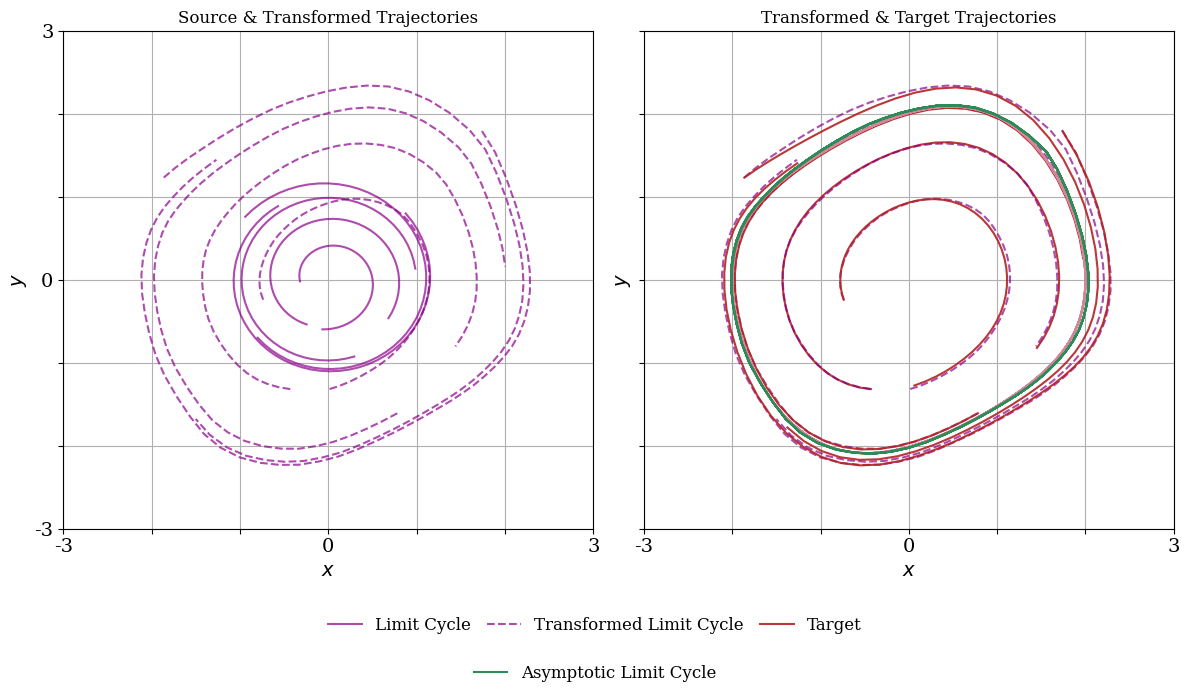

In [74]:
plot_first_n = 5
fig, axes = plot_trajectories_allmotifs(trajectories_source_list[:], transformed_trajectories_list[:], trajectories_target_array[:plot_first_n,:], bounds=(3.0, 3.0),
                            source_names=['Limit Cycle', 'Ring Attractor', 'Linear'],
                            asymptotic_trajectories_list=asymptotic_trajectories_list,
                             save_name='figures/node_vdp_lc_speed_asym.pdf')

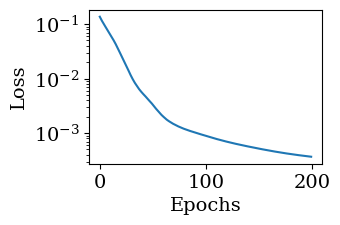

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(homeo_lc.losses)
ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.show()

# Normalizing flow

In [ ]:
num_epochs = 100
layer_sizes=4*[64]
np.random.seed(42)
homeo_lc = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_ra = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_net_linear = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_networks = [homeo_lc, homeo_ra, homeo_net_linear]
homeo_networks = train_all_motifs(motif_library, homeo_networks, trajectories_target, initial_conditions_target,
                                   lr=0.0001, num_epochs=num_epochs)

Training diffeomorphism for motif: LimitCycle
Epoch 0, Loss: 0.3087
Epoch 10, Loss: 0.2702
Epoch 20, Loss: 0.2223
Epoch 30, Loss: 0.1663
Epoch 40, Loss: 0.1031
Epoch 50, Loss: 0.0505
Epoch 60, Loss: 0.0416
Epoch 70, Loss: 0.0387
Epoch 80, Loss: 0.0364
Epoch 90, Loss: 0.0349
Total training time: 121.51 seconds, Avg time per epoch: 1.2151 sec
Training diffeomorphism for motif: RingAttractor
Epoch 0, Loss: 2.1926
Epoch 10, Loss: 2.1171
Epoch 20, Loss: 2.0379
Epoch 30, Loss: 1.9570
Epoch 40, Loss: 1.8790
Epoch 50, Loss: 1.8091
Epoch 60, Loss: 1.7494
Epoch 70, Loss: 1.6977
Epoch 80, Loss: 1.6512
Epoch 90, Loss: 1.6106
Total training time: 117.16 seconds, Avg time per epoch: 1.1716 sec
Training diffeomorphism for motif: LinearSystem
Epoch 0, Loss: 1.5209
Epoch 10, Loss: 1.5166
Epoch 20, Loss: 1.5161
Epoch 30, Loss: 1.5162
Epoch 40, Loss: 1.5150
Epoch 50, Loss: 1.5128
Epoch 60, Loss: 1.5079
Epoch 70, Loss: 1.4966
Epoch 80, Loss: 1.4736
Epoch 90, Loss: 1.4395
Total training time: 102.22 second

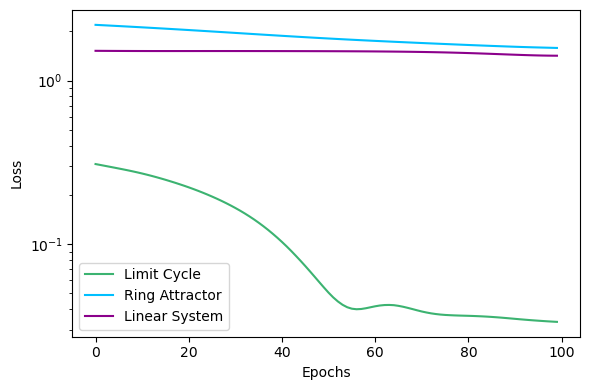

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
motif_names = ['Limit Cycle', 'Ring Attractor', 'Linear System']
motif_colors = ["mediumseagreen", "#00BFFF", "#8B008B"]

for i in range(len(motif_library)):
    ax.plot(homeo_networks[i].losses, label=motif_names[i], color=motif_colors[i])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
#find asymptotic behavior of target and source motifs
time_span = np.array([0.0, 100.0])
plot_first_n = 1

t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=bounds,                 # Define the bounds for initial conditions
    time_span=torch.tensor(time_span), # Time span for trajectory generation
    dt=dt, num_points=plot_first_n,                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
trajectories_source_list, transformed_trajectories_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy,
    plot_first_n, plot_first_n=plot_first_n,
        time_span = time_span

)

c:\Users\abel_\Documents\Lab\Projects\topological_diversity\iam\scripts\ds_class.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


(1, 2000, 2)

['Target', 'Transformed Limit Cycle', 'Transformed Ring Attractor', 'Transformed Linear']


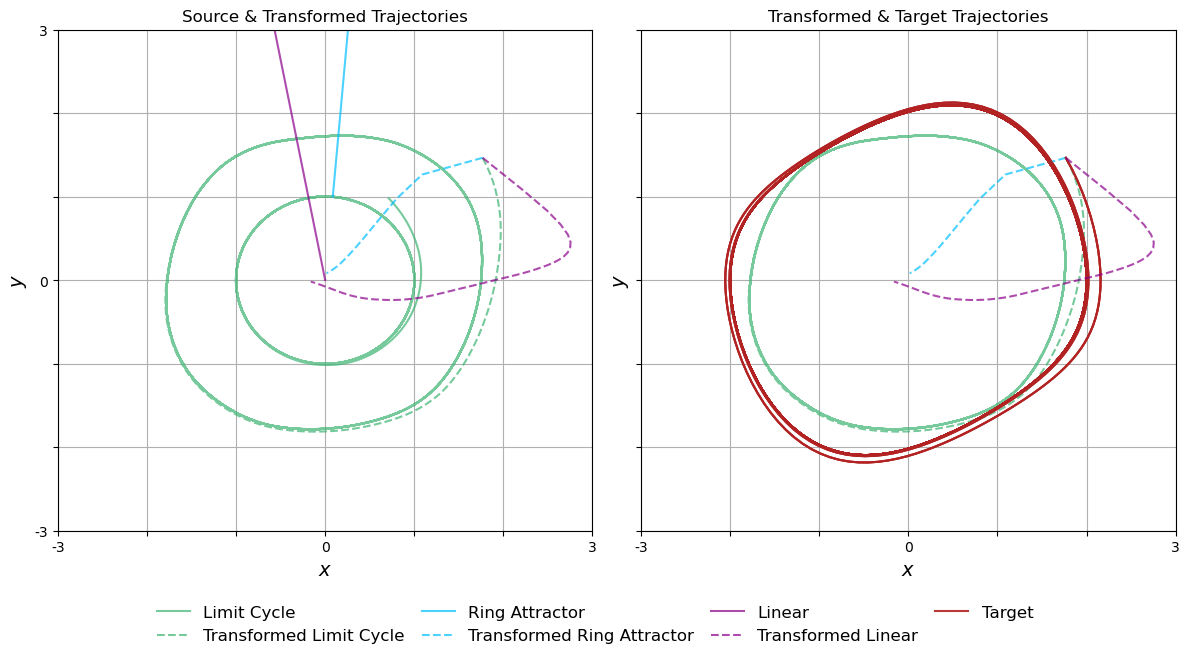

In [ ]:
from_t = 100
fig, axes = plot_trajectories_allmotifs(trajectories_source_list[:], transformed_trajectories_list[:], trajectories_target_array[:plot_first_n,:], bounds=(3.0, 3.0),
                            source_names=['Limit Cycle', 'Ring Attractor', 'Linear'],
                            save_name=f'figures/nf_epoch{num_epochs}_all_motifs_vdp_ntraj{plot_first_n}.pdf')